In [1]:
!pip install pygame

In [2]:
%pip install gymnasium

Note: you may need to restart the kernel to use updated packages.


In [3]:
import gymnasium as gym
import pygame

from collections import defaultdict

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pdb
import time
from IPython.display import clear_output
import random

np.random.seed(42)

### Environment characteristics:

The environment is taken from the OpenAI Gym library. The environment used is to taken to provide the Frozen Lake game.
\
\
The aim of this game is to cross a frozen lake, starting from an initial position, S, to a Goal position, G, walking over the frozen lake, F, which is safe, without falling into hole, H.

##### Action Space

The agent can do 4 possible actions, navigate **left**, **right**, **up** and **down**. The game ends when the agent reaches the goal or fall in a hole.\
\
The agent takes one element vector action per time.

##### State Space

The state space is defined by a value which rappresent the agent current position, and it is calculeted as: *current row + current columns*.

##### Reward Schedule

The reward can be 0 or 1. If the agent reaches the goal, G, the reward is equal to 1, otherwise is 0.

In [5]:
env = gym.make('FrozenLake-v1')
print(env.reset()[0])
print(f'State Space: {env.observation_space}')
print(f'Action Space: {env.action_space}')

0
State Space: Discrete(16)
Action Space: Discrete(4)


In [6]:
print(env.step(0))

(0, 0.0, False, False, {'prob': 0.3333333333333333})


### Monte Carlo

In [8]:
def random_policy(env):
    policy = {}
    for key in range(0, env.observation_space.n):
        current_end = 0
        p = {}
        for action in range(0, env.action_space.n):
            p[action] = 1 / env.action_space.n
        policy[key] = p
    return policy

In [9]:
def state_action_dictionary(env, policy):
    Q = {}
    for key in policy.keys():
         Q[key] = {a: 0.0 for a in range(0, env.action_space.n)}
    return Q

In [10]:
def run_game(env, policy, display=True):
    env.reset()
    episode = []
    finished = False

    while not finished:
        s = env.env.s
        if display:
            clear_output(True)
            env.render()
            sleep(1)

        timestep = []
        timestep.append(s)
        n = random.uniform(0, sum(policy[s].values()))
        top_range = 0
        for prob in policy[s].items():
                top_range += prob[1]
                if n < top_range:
                    action = prob[0]
                    break 
        state, reward, finished, info, prob = env.step(action)
        timestep.append(action)
        timestep.append(reward)

        episode.append(timestep)

    if display:
        clear_output(True)
        env.render()
        sleep(1)
    return episode

In [11]:
def test_policy(policy, env):
    wins = 0
    r = 100
    for i in range(r):
        w = run_game(env, policy, display=False)[-1][-1]
        if w == 1:
                wins += 1
    return wins / r

In [12]:
def monte_carlo_e_soft(env, episodes=100, policy=None, epsilon=0.01):
    if not policy:
        policy = random_policy(env)  # Create an empty dictionary to store state action values    
    Q = state_action_dictionary(env, policy) # Empty dictionary for storing rewards for each state-action pair
    returns = {}
    
    for _ in range(episodes): # Looping through episodes
        G = 0 # Store cumulative reward in G (initialized at 0)
        episode = run_game(env=env, policy=policy, display=False) # Store state, action and value respectively 
        
        # for loop through reversed indices of episode array. 
        # The logic behind it being reversed is that the eventual reward would be at the end. 
        # So we have to go back from the last timestep to the first one propagating result from the future.
        
        for i in reversed(range(0, len(episode))):   
            s_t, a_t, r_t = episode[i] 
            state_action = (s_t, a_t)
            G += r_t # Increment total reward by reward on current timestep
            
            if not state_action in [(x[0], x[1]) for x in episode[0:i]]: # 
                if returns.get(state_action):
                    returns[state_action].append(G)
                else:
                    returns[state_action] = [G]   
                    
                Q[s_t][a_t] = sum(returns[state_action]) / len(returns[state_action]) # Average reward across episodes
                
                Q_list = list(map(lambda x: x[1], Q[s_t].items())) # Finding the action with maximum value
                indices = [i for i, x in enumerate(Q_list) if x == max(Q_list)]
                max_Q = random.choice(indices)
                
                A_star = max_Q
                
                for a in policy[s_t].items(): # Update action probability for s_t in policy
                    if a[0] == A_star:
                        policy[s_t][a[0]] = 1 - epsilon + (epsilon / abs(sum(policy[s_t].values())))
                    else:
                        policy[s_t][a[0]] = (epsilon / abs(sum(policy[s_t].values())))

    return policy

#### Run the MC algorithm

In [13]:
policy = monte_carlo_e_soft(env, episodes=1000)
test_policy(policy, env)

c:\Users\lucam\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.s to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.s` for environment variables or `env.get_wrapper_attr('s')` that will search the reminding wrappers.
  logger.warn(


0.57

### Q-learning

In [14]:
class Q_learn:

  def __init__(self,env):
    self.env=env  # Env already defined


  def QTable(self):
    self.q_table = np.zeros([self.env.observation_space.n,self.env.action_space.n])
    return self.q_table


  def train(self,epoch=100001,alpha = 0.1,gamma = 0.6,epsilon = 0.1):
    self.QTable()
    for i in range(1, epoch):
        # Reset the action made in the environments
        state = self.env.reset()[0]
        # Sure that the agent is not in G
        done = False
        # Impose the reward and epochs null
        epochs, reward = 0, 0
        

        while not done:
            if random.uniform(0, 1) < epsilon:
                # We made exploration of the action space (the action provide will be random in such a way to explore a random state)
                action = self.env.action_space.sample()
            else:
                # Exploitation --> get the action which provide the maximum Q-value in the current state
                action = np.argmax(self.q_table[state])

            # Update the agent with the new info getting after provide the action    
            next_state, reward, done, info, prob = self.env.step(action) 
            
            # Update the Q-table using the Bellman equation
            old_value = self.q_table[state, action] # Old Q-table value
            next_max = np.max(self.q_table[next_state]) # learned value
            
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            self.q_table[state, action] = new_value

            state = next_state
            epochs += 1
            
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")

    print("Training finished.\n")

  def trainTune(self,alpha = 0.5,gamma = 0.8,epsilon = 0.6):
    self.QTable()
    for i in range(1, 100001):
        state = self.env.reset()[0]
        epochs, reward, = 0, 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = self.env.action_space.sample() # Explore action space
            else:
                action = np.argmax(self.q_table[state]) # Exploit learned values

            next_state, reward, done, info, prob = self.env.step(action) 
            
            old_value = self.q_table[state, action]
            next_max = np.max(self.q_table[next_state])
            
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            self.q_table[state, action] = new_value

            state = next_state
            epochs += 1
            
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")
        if i % 1000 == 0:
            epsilon-=0.0058
            gamma-=0.0078
            alpha-=0.0048
            print(epsilon,gamma,alpha,sep='\n')

    print("Training finished.\n")
  def trainGraidSearch(self,hyper):
    self.QTable()
    df=pd.DataFrame(columns=['epoch','alpha','gama','epsilon','average Time'])
    epochF=False
    alphaF=False
    gammaF=False
    epsilonF=False
    try:
      epochs=hyper['epochs']
      epochF=True
    except:
      epochs=[100001]
    try:
      alphas=hyper['alphas']
      alphaF=False
    except:
      alphas=[0.1]
    try:
      gammas=hyper['gammas']
      gammaF=True
    except:
      gammas=[0.6]
    try:
      epsilons=hyper['epsilons']
      epsilonF=True
    except:
      epsilons=[0.1]
    first=True
    best_parameter=[]
    for epoch in epochs:
      for alpha in alphas:
        for gamma in gammas:
          for epsilon in epsilons:
            self.train(epoch,alpha,gamma,epsilon)
            average=self.evaloute()
            df.loc[len(df.index)]=[epoch,alpha,gamma,epsilon,average]
            display(df)
    best_parmeter=df.loc[df['average Time'].idxmin()]
    return best_parmeter 


  def evaloute(self,episodes = 100):
    total_epochs= 0
    for _ in range(episodes):
        state = self.env.reset()[0]
        epochs, reward = 0, 0
        done = False
        
        while not done:
            action = np.argmax(self.q_table[state])
            state, reward, done, info, prob = self.env.step(action)
            epochs += 1
        total_epochs += epochs
    average=total_epochs / episodes
    print(f"Results after {episodes} episodes:")
    print(f"Average timesteps per episode: {average}")
    return average


Train the Agent using Q-learning: 

In [15]:
RL_model3=Q_learn(env)
RL_model3.train()

Episode: 100000
Training finished.



In [16]:
RL_model3.evaloute()


Results after 100 episodes:
Average timesteps per episode: 10.92


10.92

In [17]:
RL_model3.trainTune()
RL_model3.evaloute()

Episode: 100000
0.019999999999998352
0.01999999999999974
0.019999999999998685
Training finished.

Results after 100 episodes:
Average timesteps per episode: 5.33


5.33

### Deep Q-learning

In [17]:
Q_table = np.zeros([env.observation_space.n, env.action_space.n])
lr = 0.85
gamma = 0.99
num_episodes = 2000
num_iterations = 200
rewards = np.zeros(num_episodes)

In [18]:
for episode in range(num_episodes):
    state = env.reset()[0]
    for iteration in range(num_iterations):
            action = np.argmax(Q_table[state,:] + np.random.randn(1, env.action_space.n)*(1./(episode+1)))
            next_state, reward, done, info, prob = env.step(action) 
            
            Q_table[state, action] = Q_table[state, action] + lr*(reward + gamma*np.max(Q_table[next_state,:]) - Q_table[state, action])
            state = next_state
            
            if done or iteration == num_iterations-1:
                rewards[episode] = reward
            if done:
                break

In [19]:
def find_conseq_max():
    sum_cur = sum(rewards[0:100])
    max_ = sum_cur
    for i in range(100, num_episodes):
        sum_cur += rewards[i] - rewards[i-100]
        max_ = max(max_, sum_cur)
    return max_/100

In [20]:
print(find_conseq_max())

0.84


class DQNAgent:
    def __init__(self):
        self.state_dim = 3
        self.action_dim = 9
        self.lr = 0.01
        self.gamma = 0.98
        self.tau = 0.01
        self.epsilon = 1.0
        self.epsilon_decay = 0.98
        self.epsilon_min = 0.001
        self.buffer_size = 100000
        self.batch_size = 200
        self.memory = ReplayBuffer(self.buffer_size)
        
        self.Q = Qnetwork(self.state_dim, state.action_dim, state.lr)
        self.Qtarget = Qnetwork(self.state_dim, state.action_dim, state.lr)
        self.Qtarget.load_state_dict(self.Q.state_dict())

class ReplayBuffer:
    def __init__(self, buffer_limit):
        self.buffer = duque(maxlen=buffer_limit)
        
    def put(self, transition):
        self.buffer.append(transation)

In [14]:
# Build the neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import gymnasium as gym
import os

dir = "trained_agents"
if not os.path.exists(dir):
    os.makedirs(dir)

class DQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)  
    
    def __len__(self):
        return len(self.memory)


class FrozenLake():
    # Hyperparameters
    lr = 0.005 # Learning rate
    epsilon_rate = 1 # Exploration rate
    epsilon_min = 0.1
    epsilon_decay = 0.998
    gamma = 0.9 # Discount factor
    update_rate = 10 # Update target network every 10 episodes
    replay_memory_size = 1000 # Replay memory size
    batch_size = 64 # Number of samples to take from replay memory
    checkpoint_episode = 200 # Save model checkpoint every 100 episodes

    ACTIONS = ['L', 'D', 'R', 'U'] # Left, Down, Right, Up

    def train(self, episodes, render=False, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=is_slippery, render_mode='human' if render else None)
        states = env.observation_space.n
        actions = env.action_space.n

        memory = ReplayMemory(self.replay_memory_size)

        policy_net = DQNetwork(states, actions)
        target_net = DQNetwork(states, actions)

        target_net.load_state_dict(policy_net.state_dict())

        print('Training on', 'slippery' if is_slippery else 'non-slippery', 'FrozenLake')

        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(policy_net.parameters(), lr=self.lr)

        rewards_per_episode = np.zeros(episodes)

        epsilon_rate_history = []

        steps = 0

        for episode in range(episodes): # Loop through episodes
            state = env.reset()[0]
            done = False # True if agent stepped on a hole or reached the goal
            stop = False # True if agent takes too long to solve the environment

            while not done and not stop:
                # Epsilon_rate-greedy policy
                if random.random() < self.epsilon_rate:
                    # take a random action
                    action = env.action_space.sample()
                else:
                    # take the action with the highest Q-value
                    with torch.no_grad(): # Disable gradient tracking since we are not training
                        action = policy_net(self.state_to_dqn_input(state, states)).argmax().item()
                
                new_state, reward, done, stop, _ = env.step(action)
                memory.append((state, action, reward, new_state, done))

                state = new_state
                steps += 1

            if reward == 1:
                rewards_per_episode[episode] = 1

            if len(memory) >= self.batch_size and np.sum(rewards_per_episode) > 0:
                batch = memory.sample(self.batch_size) # Sample a batch of transitions
                self.optimize(batch, policy_net, target_net) # Optimize the policy network passing the batch

            if self.epsilon_rate > self.epsilon_min:
                self.epsilon_rate *= self.epsilon_decay
                epsilon_rate_history.append(self.epsilon_rate)

                if steps > self.update_rate:
                    target_net.load_state_dict(policy_net.state_dict())
                    steps = 0

            if done:
                print(f"episode: {episode}/{episodes}, return: {rewards_per_episode[episode]}, epsilon: {self.epsilon_rate:.2f}")

            if episode % self.checkpoint_episode == 0:
                torch.save(policy_net.state_dict(), f"{dir}/policy_net{episode}.pth")
                
        env.close()


    def state_to_dqn_input(self, state:int, states:int)->torch.Tensor:
        '''
        Converts a state to a tensor that can be used as input to the DQN (encoded as one-hot)
        '''	
        input_tensor = torch.zeros(states)
        state = int(state)
        input_tensor[state] = 1
        return input_tensor

    
    def optimize(self, batch, policy_net, target_net):

        states = policy_net.fc1.in_features
        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, done in batch:
            if done:
                # If the episode is done, the target is the reward (0 if the agent fell in a hole, 1 if it reached the goal)
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.gamma * target_net(self.state_to_dqn_input(new_state, states)).max()
                    )

            # Get the current set of Q values
            current_q = policy_net(self.state_to_dqn_input(state, states))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_net(self.state_to_dqn_input(state, states))
            # Adjust the specific action to the target that was just calculated. 
            # Target_q[batch][action], hardcode batch to 0 because there is only 1 batch.
            target_q[action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def test(self, episodes, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=is_slippery, render_mode='human')
        states = env.observation_space.n
        actions = env.action_space.n

        # Load learned policy
        policy_net = DQNetwork(states, actions)
        policy_net.load_state_dict(torch.load("policy_net.pth"))
        policy_net.eval()    # switch model to evaluation mode

       
        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            done = False      # True when agent falls in hole or reached goal
            stop = False       # True when agent takes more than 200 actions            

            # Agent navigates map until it falls into a hole (done), reaches goal (done), or has taken 200 actions (stop).
            while(not done and not stop):  
                # Select best action   
                with torch.no_grad():
                    action = policy_net(self.state_to_dqn_input(state, states)).argmax().item()

                # Execute action
                state,reward,done,stop,_ = env.step(action)

        env.close()

if __name__ == '__main__':

    frozen_lake = FrozenLake()
    is_slippery = False
    frozen_lake.train(2000, is_slippery=is_slippery)
    frozen_lake.test(10, is_slippery=is_slippery)


In [19]:
class FrozenLake():
    # Hyperparameters
    lr = 0.003 # Learning rate
    epsilon_rate = 1 # Exploration rate
    epsilon_min = 0.1
    epsilon_decay = 0.998
    gamma = 0.9 # Discount factor
    update_rate = 10 # Update target network every 10 episodes
    replay_memory_size = 500 # Replay memory size
    batch_size = 64 # Number of samples to take from replay memory
    checkpoint_episode = 200 # Save model checkpoint every 100 episodes

    ACTIONS = ['L', 'D', 'R', 'U'] # Left, Down, Right, Up

    def train(self, episodes, render=False, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=is_slippery, render_mode='human' if render else None)
        states = env.observation_space.n
        actions = env.action_space.n

        memory = ReplayMemory(self.replay_memory_size)

        policy_net = DQNetwork(states, actions)
        target_net = DQNetwork(states, actions)

        target_net.load_state_dict(policy_net.state_dict())

        print('Training on', 'slippery' if is_slippery else 'non-slippery', 'FrozenLake')

        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(policy_net.parameters(), lr=self.lr)

        rewards_per_episode = np.zeros(episodes+1)

        epsilon_rate_history = []
        returns = [] # List to store returns for each episode

        steps = 0

        for episode in range(1, episodes+1): # Loop through episodes
            state = env.reset()[0]
            done = False # True if agent stepped on a hole or reached the goal
            stop = False # True if agent takes too long to solve the environment
            total_reward = 0

            while not done and not stop:
                # Epsilon_rate-greedy policy
                if random.random() < self.epsilon_rate:
                    # take a random action
                    action = env.action_space.sample()
                else:
                    # take the action with the highest Q-value
                    with torch.no_grad(): # Disable gradient tracking since we are not training
                        action = policy_net(self.state_to_dqn_input(state, states)).argmax().item()
                
                new_state, reward, done, stop, _ = env.step(action)
                memory.append((state, action, reward, new_state, done))

                state = new_state
                total_reward += reward
                steps += 1

            rewards_per_episode[episode] = total_reward
            returns.append(total_reward) # Track the return

            if len(memory) >= self.batch_size and np.sum(rewards_per_episode) > 0:
                batch = memory.sample(self.batch_size) # Sample a batch of transitions
                self.optimize(batch, policy_net, target_net) # Optimize the policy network passing the batch

            if self.epsilon_rate > self.epsilon_min:
                self.epsilon_rate *= self.epsilon_decay
                epsilon_rate_history.append(self.epsilon_rate)

                if steps > self.update_rate:
                    target_net.load_state_dict(policy_net.state_dict())
                    steps = 0

            if done:
                print(f"episode: {episode}/{episodes}, return: {rewards_per_episode[episode]}, epsilon: {self.epsilon_rate:.2f}")

            if episode % self.checkpoint_episode == 0:
                torch.save(policy_net.state_dict(), f"policy_net{episode}.pth")
                
        env.close()
        return returns

    def state_to_dqn_input(self, state:int, states:int)->torch.Tensor:
        '''
        Converts a state to a tensor that can be used as input to the DQN (encoded as one-hot)
        '''	
        input_tensor = torch.zeros(states)
        state = int(state)
        input_tensor[state] = 1
        return input_tensor

    
    def optimize(self, batch, policy_net, target_net):

        states = policy_net.fc1.in_features
        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, done in batch:
            if done:
                # If the episode is done, the target is the reward (0 if the agent fell in a hole, 1 if it reached the goal)
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.gamma * target_net(self.state_to_dqn_input(new_state, states)).max()
                    )

            # Get the current set of Q values
            current_q = policy_net(self.state_to_dqn_input(state, states))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_net(self.state_to_dqn_input(state, states))
            # Adjust the specific action to the target that was just calculated. 
            # Target_q[batch][action], hardcode batch to 0 because there is only 1 batch.
            target_q[action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def test(self, episodes, render=True, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=is_slippery, render_mode='human' if render else None)
        states = env.observation_space.n
        actions = env.action_space.n

        # Load learned policy
        policy_net = DQNetwork(states, actions)
        policy_net.load_state_dict(torch.load("policy_net2000.pth"))
        policy_net.eval()    # switch model to evaluation mode

        total_rewards = []  # To track rewards over episodes
        
        for i in range(1, episodes+1):
            state = env.reset()[0]  # Initialize to state 0
            done = False      # True when agent falls in hole or reached goal
            stop = False       # True when agent takes more than 200 actions
            total_reward = 0  # To track total reward per episode            

            # Agent navigates map until it falls into a hole (done), reaches goal (done), or has taken 200 actions (stop).
            while(not done and not stop):  
                # Select best action   
                with torch.no_grad():
                    action = policy_net(self.state_to_dqn_input(state, states)).argmax().item()

                # Execute action
                state, reward, done, stop, _ = env.step(action)
                total_reward += reward

            total_rewards.append(total_reward)
            print(f"Episode {i}: Total Reward: {total_reward}")

        env.close()
        return total_rewards

        average_return = np.mean(total_rewards)
        print(f"Average return over {episodes} episodes: {average_return}")

        return total_rewards, average_return


Training on non-slippery FrozenLake
episode: 1/2000, return: 0.0, epsilon: 1.00
episode: 2/2000, return: 0.0, epsilon: 1.00
episode: 3/2000, return: 0.0, epsilon: 0.99
episode: 4/2000, return: 0.0, epsilon: 0.99
episode: 5/2000, return: 1.0, epsilon: 0.99
episode: 6/2000, return: 0.0, epsilon: 0.99
episode: 7/2000, return: 0.0, epsilon: 0.99
episode: 8/2000, return: 0.0, epsilon: 0.98
episode: 9/2000, return: 0.0, epsilon: 0.98
episode: 10/2000, return: 0.0, epsilon: 0.98
episode: 11/2000, return: 0.0, epsilon: 0.98
episode: 12/2000, return: 0.0, epsilon: 0.98
episode: 13/2000, return: 0.0, epsilon: 0.97
episode: 14/2000, return: 1.0, epsilon: 0.97
episode: 15/2000, return: 0.0, epsilon: 0.97
episode: 16/2000, return: 0.0, epsilon: 0.97
episode: 17/2000, return: 0.0, epsilon: 0.97
episode: 18/2000, return: 0.0, epsilon: 0.96
episode: 19/2000, return: 0.0, epsilon: 0.96
episode: 20/2000, return: 0.0, epsilon: 0.96
episode: 21/2000, return: 0.0, epsilon: 0.96
episode: 22/2000, return: 0.

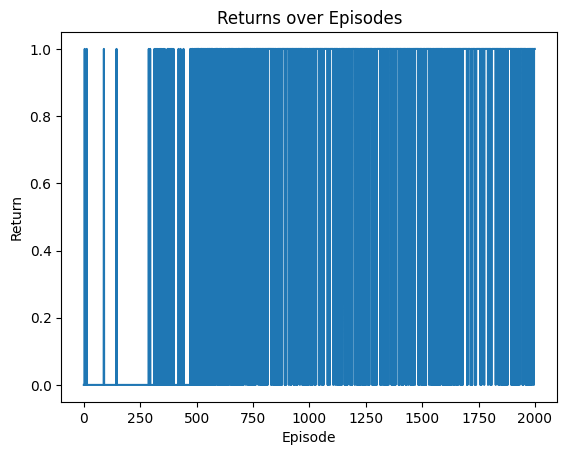

In [20]:
# Train the model and get returns
fl = FrozenLake()
returns = fl.train(episodes=2000, render=False, is_slippery=False)

# Plot the returns
plt.plot(returns)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Returns over Episodes')
plt.show()

In [21]:
# Evaluate the model
test_rewards = fl.test(episodes=10, render=True, is_slippery=False)


Episode 1: Total Reward: 0.0
Episode 2: Total Reward: 0.0
Episode 3: Total Reward: 0.0
Episode 4: Total Reward: 0.0
Episode 5: Total Reward: 0.0
Episode 6: Total Reward: 0.0
Episode 7: Total Reward: 0.0
Episode 8: Total Reward: 0.0


KeyboardInterrupt: 

: 